# Gaussian Mixture Model

Gaussian mixture models (GMM) are used for clustering data points. Here we implement a simple Bayesian GMM using Pyro. We make use of the parallel discrete enumeration module in Pyro which allows for efficient inference in models where both continuous and discrete variables exist.

### First we draw the graphical model

<div style="text-align:center">
    <img src="figs/gmm.png" style="height:300px" />
</div>

### Next we write down the generative process of the data given $X_{1:n} \in \mathrm{R}^D$.

$$
\large {
\pi_{1:K} \sim \text{Dir}([10,\dots,10])\\
\mu_{j} \sim \mathcal{N}([0,\dots,0],20 \times \mathcal{I}_D) \quad j=1,\dots,K\\
Z_{i} | \pi_{1:K} \sim \text{Cat}(\pi_{1:K}) \quad i=1,\dots,N\\
X_{i} | Z_{i} \sim \mathcal{N}(\mu_{Z_i},\mathcal{I}_D) \quad i=1,\dots,N
}
$$

In [174]:
from pyro.infer import SVI, TraceTMC_ELBO, config_enumerate, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDelta, AutoNormal
from torch.distributions import constraints
from collections import defaultdict
from pyro.ops.indexing import Vindex
import pyro.distributions as dist
from functools import partial
from pyro.optim import Adam
import visualization as V
from pyro import poutine
import torch
import pyro

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


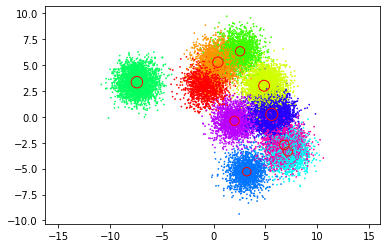

In [179]:
# GMM function both for generating samples and running inference

@config_enumerate
def GMM(data=None,N=100,K=2,D=2):
    # Weights of the GMM have to sum to one, so we draw from Dirichlet
    weights = pyro.sample('weights', dist.Dirichlet(10 * torch.ones(K)))
    
    # Generating cluster centers in a plate with size K
    with pyro.plate('components', K):
        # Assuming multivariate normal prior over the cluster centers
        locs = pyro.sample('locs', dist.MultivariateNormal(torch.zeros(D),20*torch.eye(D)))

    # Generating local assignment variables and conditioning on observations
    with pyro.plate('data', N):
        # Assignment is a cluster index between 0 and K, so we draw from a Categorical 
        assignment = pyro.sample('assignment', dist.Categorical(weights),infer={"enumerate": "parallel"})
        # Given the indices, we draw each data point ceneterd at a Normal indexed by the assignment
        obs = pyro.sample('obs', dist.MultivariateNormal(locs[...,assignment,:], 1*torch.eye(D)), obs=data)
    
    return weights,locs,assignment,obs


K = 10 # number of clusters
D = 2 # dimension of the observations
N = 20000 # number of data points
pi,mu,z,data = GMM(N=N,K=K,D=D) # if we don't pass data, the function just generates samples

V.plot_gmm_2d(data,mu,pi,z)

In [180]:
# Seting random seed and clearing parameter storage
pyro.set_rng_seed(0)
pyro.clear_param_store()

# Creating an instance of a Pyro optimizer
optim = pyro.optim.Adam({'lr': 1.0})

# Approach 1: Parallel enumeration over discrete variables
# Variational family is normal distribution
guide = AutoNormal(poutine.block(partial(GMM,D=D,K=K), hide=["assignment", "obs"]))
# Cost function is Evidence Lower Bound (ELBO)
elbo = TraceEnum_ELBO(max_plate_nesting=1)
# Telling the cost function to perform parallel marginalization of the assignment variable
elbo.loss(partial(GMM,D=D,K=K), config_enumerate(guide, "parallel"))
# Creating an instance of stochastic variational inference
svi = SVI(partial(GMM,D=D,K=K), guide, optim, loss=elbo)

# Approach 2: Performing inference TraceTMC
# Variational family is delta, corresponding to MAP inference
# guide = AutoDelta(poutine.block(GMM, expose=['weights', 'locs']))
# elbo = TraceTMC_ELBO(max_plate_nesting=2)
# tmc_model = poutine.infer_config(GMM,
#     lambda msg: {"num_samples": 10, "expand": False} if msg["infer"].get("enumerate", None) == "parallel" else {},
# )
# svi = SVI(tmc_model, guide, optim, elbo)

# Keep track of the gradients and their norms through optimization
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []

In [181]:
# Running variational inference
for i in range(100):
    loss = svi.step(data,N=len(data),K=K,D=D)
    # Storing intermediate values of loss
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')



...................................................................................................

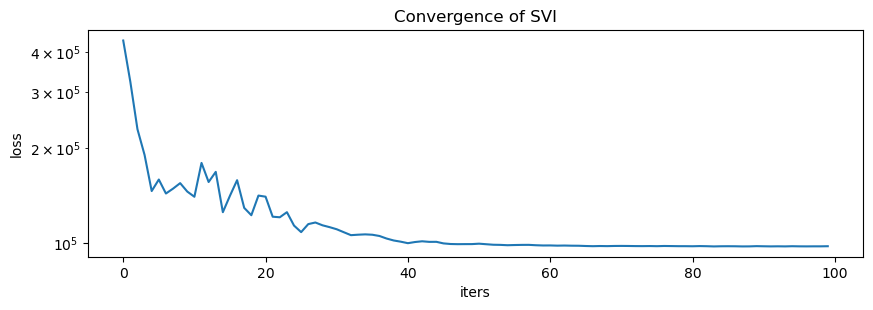

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


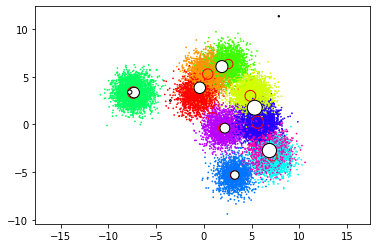

In [182]:
# Inspecting the inferred values of parameters
V.plot_loss(losses)

# Variable "estimates" encapsulates inferred parameters
estimates = guide(data)
weights = estimates['weights'].data.numpy()
locs = estimates['locs'].data.numpy()

V.plot_gmm_2d(data,mu,pi,z,weights,locs)